# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files()

In [ ]:
get_any(results)

_Result(timestamp=1609869957, cmdline=['/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', '--id', '89'], commit='9258e19b2ee7c0d36121b84e33c6fd384815b154', github_url='9258e19b2ee7c0d36121b84e33c6fd384815b154', experiment='/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', job_id=89, worker_id=89, num_workers=120, config=_config(seed=218, acquisition_size=5, max_training_set=300, num_pool_samples=20, num_eval_samples=4, num_training_samples=1, num_patience_epochs=3, max_training_epochs=10, validation_set_size=4096, initial_set_size=20, samples_per_epoch=24576, repeated_mnist_repetitions=2, add_dataset_noise=True, acquisition_function='AcquisitionFunction.random'), log=_log(), initial_training_set_indices=[38043, 40091, 17418, 2094, 39879, 3133, 5011, 40683, 54379, 24287, 9849, 59305, 39508, 39356, 8758, 52579, 13655, 7636, 21562, 41329], active_learning_steps=[_ActiveLearningStepsItem(training=_training(epochs=[_EpochsItem(accu

In [ ]:
timestamps = pd.DataFrame.from_records([dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()])

In [ ]:
timestamps

,job_id,timestamp
0,89,1609869957
1,37,1609769925
2,17,1609768518
3,105,1609776551
4,78,1609868629
...,...,...
235,28,1609860114
236,102,1609776288
237,85,1609869343
238,90,1609870034


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

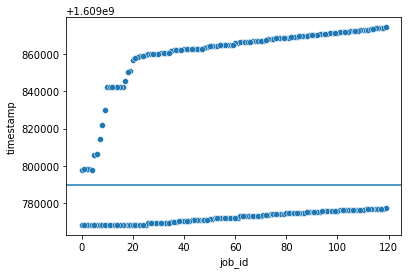

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd.axhline(y=790000+1.609e9)
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
        
    seed_acq_size_function_result[(result.config.seed, result.config.acquisition_size, result.config.acquisition_function)] = result
    
len(seed_acq_size_function_result), len(results)
#list(sorted(seed_acq_size_function_result.keys()))

(240, 240)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
        
    acquisition_size = result.config.acquisition_size
    acquisition_function = result.config.acquisition_function[len("AcquisitionFunction.") :]
    seed = result.config.seed

    if acquisition_function == "random":
        acquisition_sizes = [10, 5, 50, 20]
    else:
        acquisition_sizes = [acquisition_size]

    for acquisition_size in acquisition_sizes:
        initial_set_size = len(result.initial_training_set_indices)

        if (
            initial_set_size
            + sum(1 if hasattr(step, "evalution_metrics") else 0 for step in result.active_learning_steps)
            * result.config.acquisition_size
            < 250
        ):
            print(len(result.active_learning_steps), file)
            continue

        for i, step in enumerate(result.active_learning_steps):
            if not hasattr(step, "evalution_metrics"):
                break
            training_set_size = initial_set_size + i * result.config.acquisition_size
            accuracy = step.evalution_metrics.accuracy

            experiment_data.append(
                dict(
                    acquisition_function=acquisition_function,
                    acquisition_size=acquisition_size,
                    training_set_size=training_set_size,
                    accuracy=accuracy,
                    seed=seed
                )
            )

1 /experiment_job_17_2021-01-04-135518.py
1 /experiment_job_6_2021-01-04-135400.py
1 /experiment_job_12_2021-01-04-135554.py
1 /experiment_job_16_2021-01-04-135453.py
1 /experiment_job_2_2021-01-04-135423.py
1 /experiment_job_1_2021-01-04-135406.py
1 /experiment_job_10_2021-01-04-135410.py
1 /experiment_job_15_2021-01-04-135453.py
1 /experiment_job_8_2021-01-04-135547.py
1 /experiment_job_5_2021-01-04-135522.py
1 /experiment_job_9_2021-01-04-135346.py
1 /experiment_job_11_2021-01-04-135514.py
1 /experiment_job_14_2021-01-04-135456.py


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,training_set_size,accuracy,seed
0,random,10,20,0.5286,218
1,random,10,25,0.5695,218
2,random,10,30,0.5751,218
3,random,10,35,0.6547,218
4,random,10,40,0.7425,218
...,...,...,...,...,...
22622,random,20,280,0.9153,220
22623,random,20,285,0.9233,220
22624,random,20,290,0.9199,220
22625,random,20,295,0.9305,220


In [ ]:
import seaborn as sns

In [ ]:
df.acquisition_size.unique()

array([10,  5, 50, 20])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby("acquisition_size")["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  acquisition_function
5                 random                  80
                  thompsonbald            12
                  randombald              11
                  batchbald                8
                  bald                     7
                  batchbaldical            5
10                random                  80
                  bald                    12
                  randombald              10
                  batchbald                9
                  thompsonbald             8
                  batchbaldical            5
20                random                  80
                  thompsonbald            14
                  bald                     8
                  randombald               8
50                random                  80
                  randombald              12
                  bald                     9
                  thompsonbald             9
Name: num_trials, dtype: int64


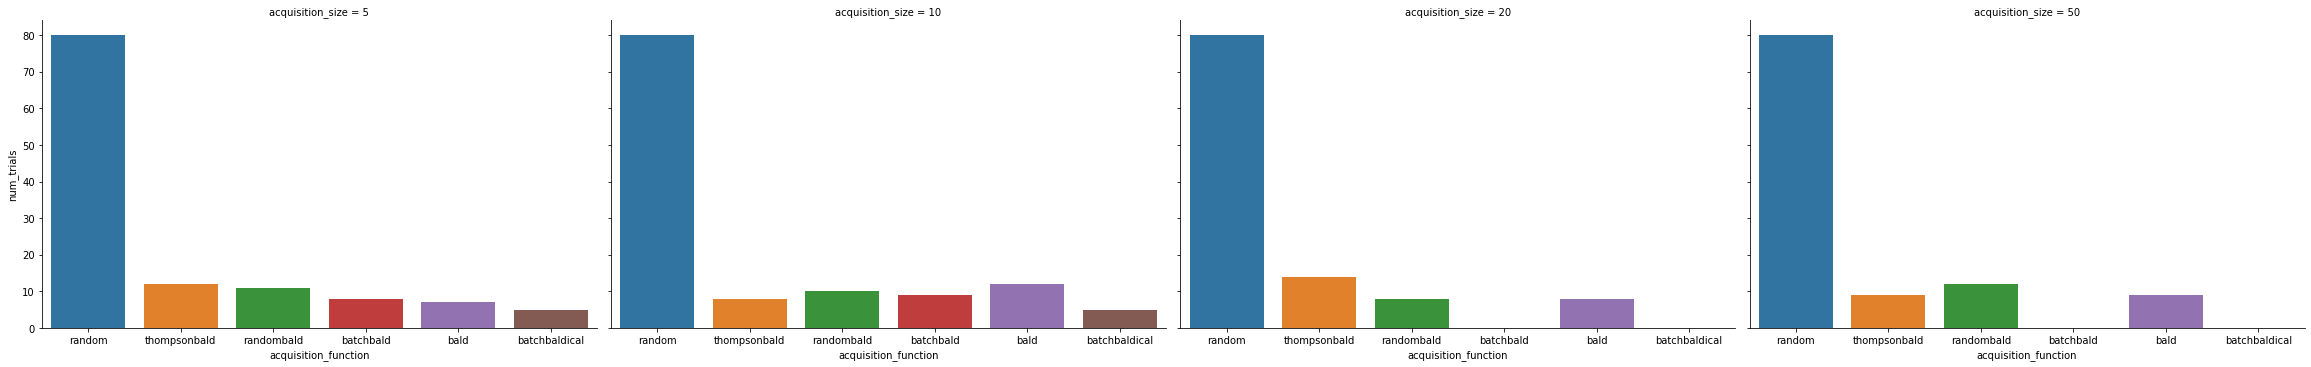

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

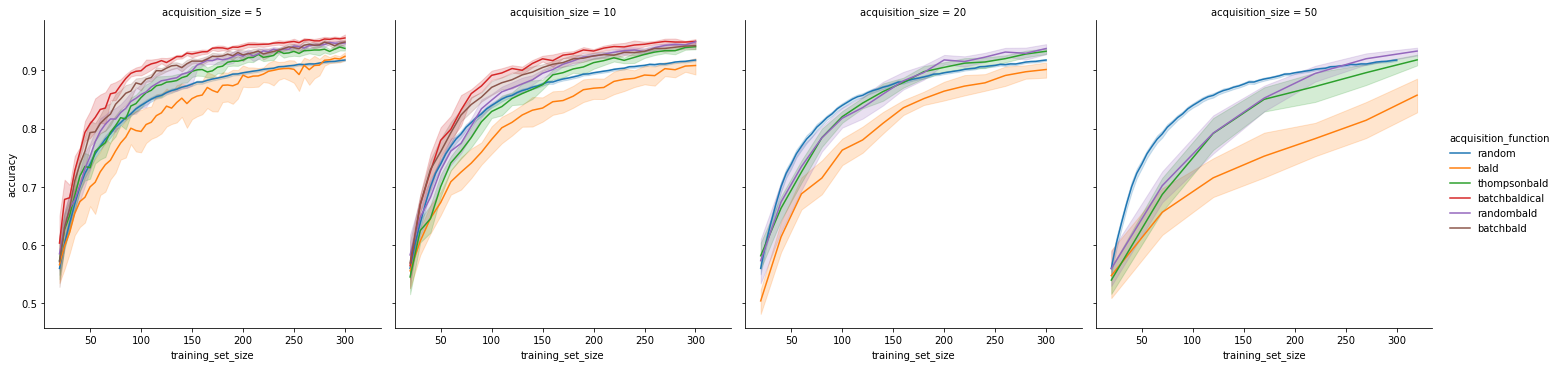

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

df["max_accuracy"] = df.groupby(["seed", "acquisition_size", "acquisition_function"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "acquisition_size", "acquisition_function", "max_accuracy"])
qgrid.show_grid(df_max_accuracy)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

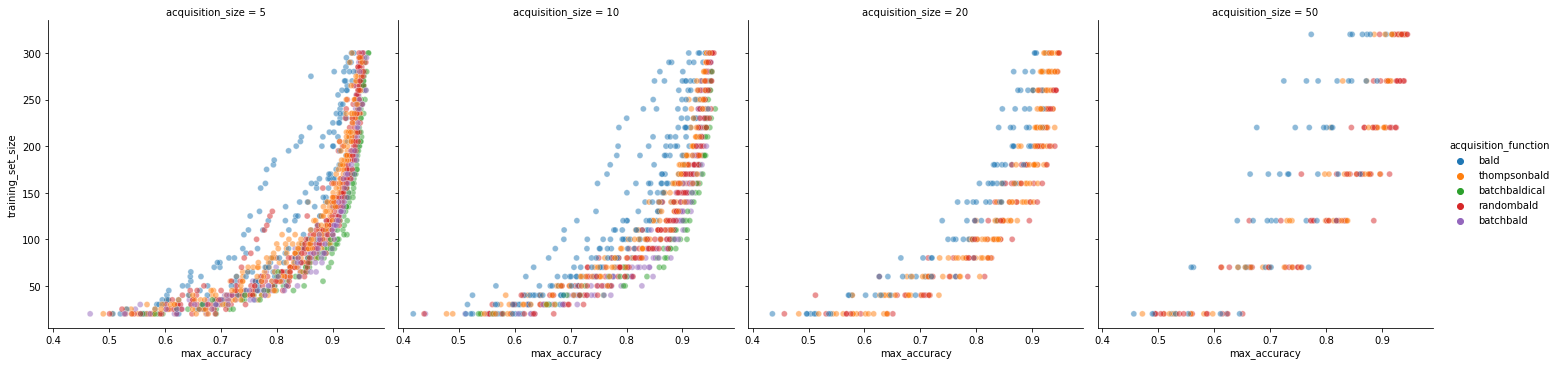

In [ ]:


grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "random"],
    kind="scatter",
    height=5,
    alpha=0.5
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[df.accuracy >= 0.90].groupby(["seed", "acquisition_size", "acquisition_function"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function"]).training_set_size.quantile([0.25,0.5,0.75])

In [ ]:
print(df3.unstack())

                                         0.25   0.50    0.75
acquisition_size acquisition_function                       
5                bald                  172.50  200.0  212.50
                 batchbald             108.75  115.0  117.50
                 batchbaldical          90.00  110.0  110.00
                 random                178.75  195.0  216.25
                 randombald            120.00  125.0  137.50
                 thompsonbald          138.75  147.5  156.25
10               bald                  212.50  220.0  262.50
                 batchbald             130.00  140.0  160.00
                 batchbaldical         110.00  120.0  120.00
                 random                178.75  195.0  216.25
                 randombald            150.00  155.0  170.00
                 thompsonbald          175.00  180.0  190.00
20               bald                  260.00  260.0  275.00
                 random                178.75  195.0  216.25
                 randomb